In [5]:
import pandas as pd
import numpy as np
import joblib
import gc
import warnings

# Veri bölme, ölçekleme ve başarı ölçen metrikleri çağırdım
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Ensemble modellerimiz: CatBoost ve Scikit-learn'ün modern Gradient Boosting yapısı
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Gereksiz uyarıları kapatıp belleği temiz tutalım
warnings.filterwarnings("ignore")
gc.collect()

print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


In [23]:
print("Veri yükleniyor...")

# Vizede kullandığımız ve model için seçtiğimiz özellikleri buraya aldım
FEATURES = [
    'LOCATION_TYPE', 
    'ROAD_TYPE_ARTERIES_HIGHWAYS', 
    'ROAD_TYPE_LOCAL_MAIN_ROADS', 
    'ROAD_TYPE_SPECIAL_AREAS'
]
TARGET = "SEVERITY"
cols_to_use = FEATURES + [TARGET]

chunks = []
# Dosyayı 50 binlik parçalar halinde okuyorum ki RAM şişmesin
try:
    for chunk in pd.read_csv("NYC_Crash_Model_Final_Last.csv", usecols=cols_to_use, chunksize=50000):
        chunk = chunk.dropna()
        # Sayısal değerleri en küçük tip olan int8'e çevirerek yer tasarrufu yapıyorum
        for col in chunk.columns:
            chunk[col] = chunk[col].astype('int8')
        chunks.append(chunk)

    # Tüm parçaları birleştirip ana tabloyu oluşturuyorum
    df_model = pd.concat(chunks, axis=0)
    del chunks
    gc.collect()

    X = df_model[FEATURES]
    y = df_model[TARGET]
    
    print(f"Veri hazır: {X.shape[0]} satır yüklendi.")

except Exception as e:
    print(f"Hata oluştu: {e}")

Veri yükleniyor...
Veri hazır: 1911073 satır yüklendi.


In [24]:
# Verinin %20'sini test için kenara ayırdım. Sınıf oranlarını korumak için stratify kullandım
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Değerleri standart bir aralığa getiriyorum, modeller bu şekilde daha stabil çalışıyor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Veri bölündü ve ölçekleme tamamlandı.")

Veri bölündü ve ölçekleme tamamlandı.


In [26]:
# Denenecek parametre aralıklarını belirliyorum
# depth: ağaçların ne kadar derine ineceği, learning_rate: modelin öğrenme hızı
depths = [4, 6, 8]
learning_rates = [0.01, 0.05, 0.1]

cat_results = []

print(f"{'Derinlik':<10} | {'LR':<10} | {'Recall':<10} | {'F1 Score':<10} | {'Accuracy':<10}")
print("-" * 75)

# Belirlediğim aralıklardaki her kombinasyonu tek tek deniyorum
for d in depths:
    for lr in learning_rates:
        # Modeli o anki parametrelerle kuruyorum
        # Sınıf dengesizliğini çözmek için 'auto_class_weights' ekliyoruz
        # Bu, az olan sınıfa (yaralı) daha çok önem vermesini sağlar
        model = CatBoostClassifier(
            iterations=200, 
            depth=d, 
            learning_rate=lr, 
            auto_class_weights='Balanced', # KRİTİK DOKUNUŞ: Model artık küçük sınıfa odaklanacak
            verbose=0,
            random_seed=42
        )
        
        # Modeli eğitiyoruz
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Başarı metriklerini hesaplıyorum
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Sonuçları anlık olarak ekrana basıyorum
        print(f"{d:<10} | {lr:<10} | {rec:.4f}     | {f1:.4f}     | {acc:.4f}")
        
        # Tüm sonuçları ve model nesnesini listede saklıyorum
        cat_results.append({
            'Model': 'CatBoost',
            'Depth': d,
            'LR': lr,
            'Recall': rec,
            'F1': f1,
            'Accuracy': acc,
            'Model_Obj': model 
        })

# Sonuçları tabloya döküp en iyi F1 skoruna göre sıralıyorum
df_cat_res = pd.DataFrame(cat_results)
best_cat_row = df_cat_res.sort_values(by="F1", ascending=False).iloc[0]

print("\nCatBoost için en iyi ayarlar bulundu.")
print(f"En İyi Derinlik: {best_cat_row['Depth']}, En İyi LR: {best_cat_row['LR']}")

# En iyi CatBoost modelini ileride kullanmak üzere kaydediyorum
final_cat_model = best_cat_row['Model_Obj']
joblib.dump(final_cat_model, "best_catboost_model_enes.pkl")

print("En iyi CatBoost modeli 'best_catboost_model_enes.pkl' olarak kaydedildi.")

Derinlik   | LR         | Recall     | F1 Score   | Accuracy  
---------------------------------------------------------------------------
4          | 0.01       | 0.8407     | 0.3728     | 0.3815
4          | 0.05       | 0.8205     | 0.3898     | 0.3917
4          | 0.1        | 0.8205     | 0.3898     | 0.3917
6          | 0.01       | 0.8407     | 0.3728     | 0.3815
6          | 0.05       | 0.8205     | 0.3898     | 0.3917
6          | 0.1        | 0.8205     | 0.3898     | 0.3917
8          | 0.01       | 0.8407     | 0.3728     | 0.3815
8          | 0.05       | 0.8205     | 0.3898     | 0.3917
8          | 0.1        | 0.8205     | 0.3898     | 0.3917

CatBoost için en iyi ayarlar bulundu.
En İyi Derinlik: 4, En İyi LR: 0.05
En iyi CatBoost modeli 'best_catboost_model_enes.pkl' olarak kaydedildi.


In [30]:
# HistGradientBoosting için deneyeceğim parametre setlerini hazırladım
# max_iter: kurulacak ağaç sayısı, learning_rate: öğrenme hızı, max_depth: ağaç derinliği
max_iter_list = [50, 100, 150]
learning_rates = [0.05, 0.1, 0.2]
max_depths = [3, 5, 8]

hgb_results = []

print(f"{'Ağaç Sayısı':<12} | {'LR':<8} | {'Derinlik':<10} | {'Recall':<10} | {'F1 Score':<10}")
print("-" * 70)

# Belirlediğim tüm varyasyonları tek tek test ediyorum
for mi in max_iter_list:
    for lr in learning_rates:
        for md in max_depths:
            # Modeli o anki döngüdeki parametrelerle kuruyorum
            model = HistGradientBoostingClassifier(
                max_iter=mi,
                learning_rate=lr,
                class_weight='balanced',
                max_depth=md,
                random_state=42
            )
            
            # Modeli eğitiyoruz
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Başarı metriklerini hesaplıyorum
            f1 = f1_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            
            # Sonuçları anlık olarak takip edebilmek için ekrana yazdırıyorum
            print(f"{mi:<12} | {lr:<8} | {md:<10} | {rec:.4f}     | {f1:.4f}")
            
            # En iyi modeli seçebilmek için tüm verileri listeye kaydediyorum
            hgb_results.append({
                'Model': 'HistGradientBoosting',
                'Iter': mi,
                'LR': lr,
                'Depth': md,
                'Recall': rec,
                'F1': f1,
                'Accuracy': acc,
                'Model_Obj': model
            })

# Tüm sonuçları bir tabloya döküp F1 skoruna göre en iyiyi buluyorum
df_hgb_res = pd.DataFrame(hgb_results)
best_hgb_row = df_hgb_res.sort_values(by="F1", ascending=False).iloc[0]

print("\nHistGradientBoosting için en iyi kombinasyon belirlendi.")
print(f"Ağaç Sayısı: {best_hgb_row['Iter']}, LR: {best_hgb_row['LR']}, Derinlik: {best_hgb_row['Depth']}")

# En iyi HGB modelini de dosya olarak kaydediyorum
final_hgb_model = best_hgb_row['Model_Obj']
joblib.dump(final_hgb_model, "best_hgb_model_enes.pkl")

print("En iyi HGB modeli 'best_hgb_model_enes.pkl' adıyla kaydedildi.")

Ağaç Sayısı  | LR       | Derinlik   | Recall     | F1 Score  
----------------------------------------------------------------------
50           | 0.05     | 3          | 0.8205     | 0.3898
50           | 0.05     | 5          | 0.8205     | 0.3898
50           | 0.05     | 8          | 0.8205     | 0.3898
50           | 0.1      | 3          | 0.8205     | 0.3898
50           | 0.1      | 5          | 0.8205     | 0.3898
50           | 0.1      | 8          | 0.8205     | 0.3898
50           | 0.2      | 3          | 0.8205     | 0.3898
50           | 0.2      | 5          | 0.8205     | 0.3898
50           | 0.2      | 8          | 0.8205     | 0.3898
100          | 0.05     | 3          | 0.8205     | 0.3898
100          | 0.05     | 5          | 0.8205     | 0.3898
100          | 0.05     | 8          | 0.8205     | 0.3898
100          | 0.1      | 3          | 0.8205     | 0.3898
100          | 0.1      | 5          | 0.8205     | 0.3898
100          | 0.1      | 8          | 0

In [32]:
# Her iki modelin en iyi sonuçlarını tek bir tabloda birleştiriyorum
summary_data = [
    {
        'Model': 'CatBoost (Ensemble)',
        'F1 Score': best_cat_row['F1'],
        'Recall (1)': best_cat_row['Recall'],
        'Accuracy': best_cat_row['Accuracy']
    },
    {
        'Model': 'HistGradientBoosting (Ensemble)',
        'F1 Score': best_hgb_row['F1'],
        'Recall (1)': best_hgb_row['Recall'],
        'Accuracy': best_hgb_row['Accuracy']
    }
]

df_ensemble_final = pd.DataFrame(summary_data)
print("ENSEMBLE MODELLERİ FİNAL KIYASLAMASI")
display(df_ensemble_final)

ENSEMBLE MODELLERİ FİNAL KIYASLAMASI


,Model,F1 Score,Recall (1),Accuracy
0,CatBoost (Ensemble),0.389759,0.820549,0.391696
1,HistGradientBoosting (Ensemble),0.389759,0.820549,0.391696


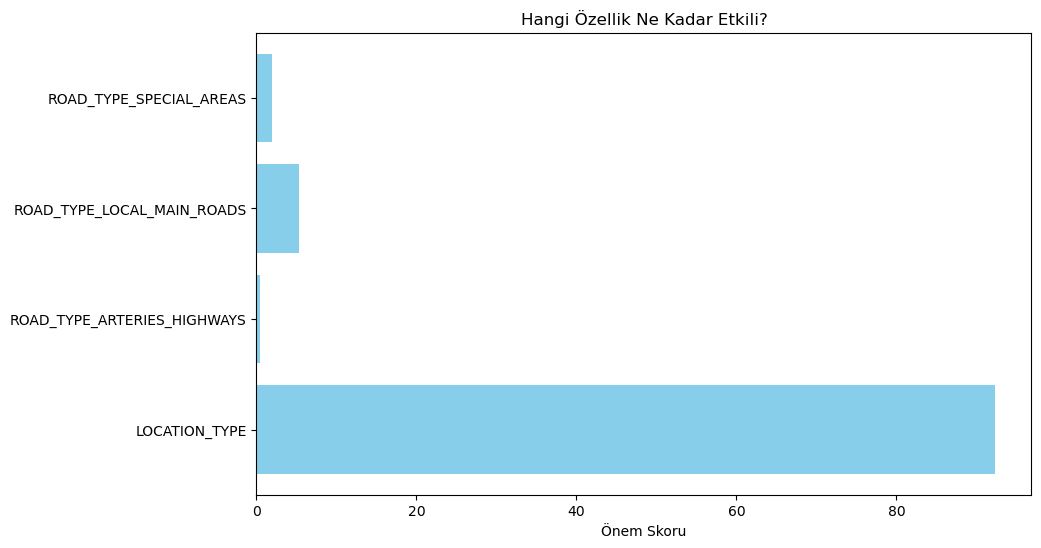

Eğer bir özelliğin skoru sıfıra yakınsa, model onu hiç kullanmıyor demektir.


In [34]:
# Modelin hangi özelliklere güvendiğini kontrol edelim
import matplotlib.pyplot as plt

# En son eğittiğimiz final_cat_model üzerinden bakalım
feature_importance = final_cat_model.get_feature_importance()
feature_names = FEATURES

# Görselleştirelim
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel('Önem Skoru')
plt.title('Hangi Özellik Ne Kadar Etkili?')
plt.show()

print("Eğer bir özelliğin skoru sıfıra yakınsa, model onu hiç kullanmıyor demektir.")

In [36]:
print("Modellerim future'larımın kararsızlığından dolayı öğrenememekte ve eksik kalmakta. Bende bu yüzden bana ayrılan konumla alakalı 2 özellik daha ekleyerek daha sağlıklı bir eğitim grafiği almayı hedefliyorum.")

Modellerim future'larımın kararsızlığından dolayı öğrenememekte ve eksik kalmakta. Bende bu yüzden bana ayrılan konumla alakalı 2 özellik daha ekleyerek daha sağlıklı bir eğitim grafiği almayı hedefliyorum.


In [38]:
print("Yeni özelliklerle veri yükleniyor...")

# Mevcut özelliklere kaza şiddetini doğrudan etkileyen yenilerini ekledik
FEATURES = [
    'LOCATION_TYPE', 
    'ROAD_TYPE_ARTERIES_HIGHWAYS', 
    'ROAD_TYPE_LOCAL_MAIN_ROADS', 
    'ROAD_TYPE_SPECIAL_AREAS',
    'IS_MULTI_VEHICLE',    # Yeni: Çoklu araç durumu
    'HOUR'           # Yeni: Kazanın saati
]

TARGET = "SEVERITY"
cols_to_use = FEATURES + [TARGET]

chunks = []
try:
    for chunk in pd.read_csv("NYC_Crash_Model_Final_Last.csv", usecols=cols_to_use, chunksize=50000):
        chunk = chunk.dropna()
        for col in chunk.columns:
            chunk[col] = chunk[col].astype('int8')
        chunks.append(chunk)

    df_model = pd.concat(chunks, axis=0)
    X = df_model[FEATURES]
    y = df_model[TARGET]
    
    print(f"Yeni veri seti hazır: {X.shape[1]} adet özellik ile {X.shape[0]} satır yüklendi.")

except Exception as e:
    print(f"Hata oluştu: {e}")

Yeni özelliklerle veri yükleniyor...
Yeni veri seti hazır: 6 adet özellik ile 1911073 satır yüklendi.


In [39]:
# Verinin %20'sini test için kenara ayırdım. Sınıf oranlarını korumak için stratify kullandım
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Değerleri standart bir aralığa getiriyorum, modeller bu şekilde daha stabil çalışıyor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Veri bölündü ve ölçekleme tamamlandı.")

Veri bölündü ve ölçekleme tamamlandı.


In [41]:
# Sınıf dengesizliğini çözmek ve skorları hareketlendirmek için 
# 'auto_class_weights' ekleyerek tekrar deniyoruz.
depths = [4, 6, 8]
learning_rates = [0.01, 0.05, 0.1]

cat_results = []
# Tablo başlığına Accuracy eklendi
print(f"{'Derinlik':<10} | {'LR':<10} | {'Recall':<10} | {'F1 Score':<10} | {'Accuracy':<10}")
print("-" * 75)

for d in depths:
    for lr in learning_rates:
        model = CatBoostClassifier(
            iterations=200, 
            depth=d, 
            learning_rate=lr, 
            auto_class_weights='Balanced', 
            verbose=0,
            random_seed=42
        )
        
        # Modeli eğitiyoruz
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Metrikleri hesaplıyoruz (Accuracy eklendi)
        f1 = f1_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        
        # Sonuçları yazdırırken Accuracy değerini de ekledik
        print(f"{d:<10} | {lr:<10} | {rec:.4f}     | {f1:.4f}     | {acc:.4f}")
        
        # Sonuç listesine Accuracy eklendi
        cat_results.append({
            'F1': f1, 
            'Accuracy': acc, 
            'Recall': rec, 
            'Model_Obj': model
        })

# En iyiyi tekrar seçelim
df_cat_res = pd.DataFrame(cat_results)
best_cat_model = df_cat_res.sort_values(by="F1", ascending=False).iloc[0]['Model_Obj']
joblib.dump(best_cat_model, "best_catboost_model_enes_v2.pkl")

print("\nYeni özelliklerle ve ağırlıklandırma ile model skorları güncellendi.")

Derinlik   | LR         | Recall     | F1 Score   | Accuracy  
---------------------------------------------------------------------------
4          | 0.01       | 0.4877     | 0.6358     | 0.6121
4          | 0.05       | 0.5242     | 0.6213     | 0.5939
4          | 0.1        | 0.5022     | 0.6306     | 0.6054
6          | 0.01       | 0.4975     | 0.6320     | 0.6072
6          | 0.05       | 0.5022     | 0.6306     | 0.6054
6          | 0.1        | 0.4923     | 0.6347     | 0.6106
8          | 0.01       | 0.5043     | 0.6301     | 0.6048
8          | 0.05       | 0.4924     | 0.6346     | 0.6105
8          | 0.1        | 0.5092     | 0.6280     | 0.6021

Yeni özelliklerle ve ağırlıklandırma ile model skorları güncellendi.


In [42]:
# HistGradientBoosting için dengeli (balanced) ağırlıklandırma ve Accuracy takibi
# max_iter: ağaç sayısı, learning_rate: öğrenme hızı, max_depth: ağaç derinliği
max_iter_list = [50, 100, 150]
learning_rates = [0.05, 0.1, 0.2]
max_depths = [3, 5, 8]

hgb_results = []

# Tablo başlığına Accuracy metriğini de ekledik
print(f"{'Ağaç Sayısı':<12} | {'LR':<8} | {'Derinlik':<10} | {'Recall':<10} | {'F1 Score':<10} | {'Accuracy':<10}")
print("-" * 85)

# Belirlenen tüm varyasyonları tek tek test ediyoruz
for mi in max_iter_list:
    for lr in learning_rates:
        for md in max_depths:
            # Scikit-learn'de sınıf dengeleme 'class_weight' parametresi ile yapılır
            model = HistGradientBoostingClassifier(
                max_iter=mi,
                learning_rate=lr,
                max_depth=md,
                class_weight='balanced', # Azınlık sınıfın (yaralı) ağırlığını artırır
                random_state=42
            )
            
            # Modeli eğitiyoruz
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Başarı metriklerini hesaplıyoruz
            f1 = f1_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            
            # Sonuçları ekrana Accuracy dahil olacak şekilde yazdırıyoruz
            print(f"{mi:<12} | {lr:<8} | {md:<10} | {rec:.4f}     | {f1:.4f}     | {acc:.4f}")
            
            # En iyi modeli seçebilmek için metrikleri ve model nesnesini kaydediyoruz
            hgb_results.append({
                'Model': 'HistGradientBoosting',
                'Iter': mi,
                'LR': lr,
                'Depth': md,
                'Recall': rec,
                'F1': f1,
                'Accuracy': acc,
                'Model_Obj': model
            })

# Tüm sonuçları bir tabloya döküp F1 skoruna göre en başarılı olanı seçiyoruz
df_hgb_res = pd.DataFrame(hgb_results)
best_hgb_row = df_hgb_res.sort_values(by="F1", ascending=False).iloc[0]

print("\nHistGradientBoosting için en iyi kombinasyon belirlendi.")
print(f"Ağaç Sayısı: {best_hgb_row['Iter']}, LR: {best_hgb_row['LR']}, Derinlik: {best_hgb_row['Depth']}")
print(f"En İyi F1 Skoru: {best_hgb_row['F1']:.4f}, Accuracy: {best_hgb_row['Accuracy']:.4f}")

# En iyi HGB modelini dosya olarak kaydediyoruz
final_hgb_model = best_hgb_row['Model_Obj']
joblib.dump(final_hgb_model, "best_hgb_model_enes_v2.pkl")

print("En iyi HGB modeli 'best_hgb_model_enes_v2.pkl' adıyla kaydedildi.")

Ağaç Sayısı  | LR       | Derinlik   | Recall     | F1 Score   | Accuracy  
-------------------------------------------------------------------------------------
50           | 0.05     | 3          | 0.4985     | 0.6309     | 0.6060
50           | 0.05     | 5          | 0.4732     | 0.6413     | 0.6194
50           | 0.05     | 8          | 0.5028     | 0.6303     | 0.6050
50           | 0.1      | 3          | 0.4968     | 0.6317     | 0.6069
50           | 0.1      | 5          | 0.4924     | 0.6346     | 0.6105
50           | 0.1      | 8          | 0.5018     | 0.6310     | 0.6059
50           | 0.2      | 3          | 0.4930     | 0.6343     | 0.6101
50           | 0.2      | 5          | 0.5015     | 0.6310     | 0.6060
50           | 0.2      | 8          | 0.5090     | 0.6280     | 0.6021
100          | 0.05     | 3          | 0.4968     | 0.6317     | 0.6069
100          | 0.05     | 5          | 0.4924     | 0.6346     | 0.6105
100          | 0.05     | 8          | 0.5117 

Ensemble modeller için ROC analizi yapılıyor...
CatBoost v2 eklendi. AUC: 0.596
HistGradientBoosting v2 eklendi. AUC: 0.598


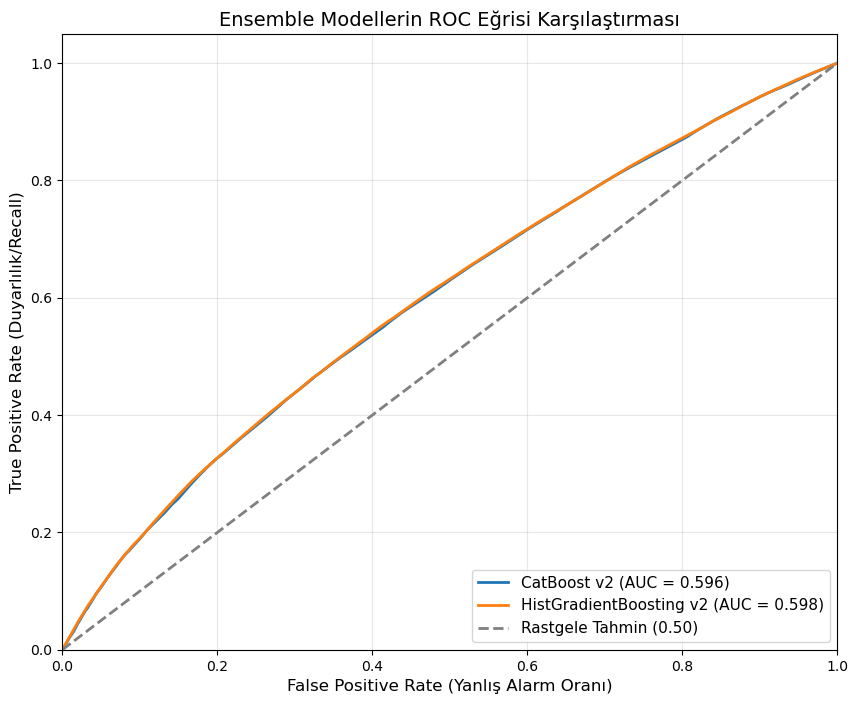

In [2]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# --- 1. VERİ HAZIRLIĞI ---
# Final modelleri 6 özellik ile eğitilmişti
FEATURES = ['LOCATION_TYPE', 'ROAD_TYPE_ARTERIES_HIGHWAYS', 'ROAD_TYPE_LOCAL_MAIN_ROADS', 
            'ROAD_TYPE_SPECIAL_AREAS', 'IS_MULTI_VEHICLE', 'HOUR']
TARGET = "SEVERITY"

# Veri setini yükle
df = pd.read_csv("NYC_Crash_Model_Final_Last.csv").dropna()

# Train-Test ayrımı (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES], df[TARGET], test_size=0.2, random_state=42, stratify=df[TARGET]
)

# --- 2. ENSEMBLE MODELLERİ YÜKLEME ---
ensemble_models = {
    "CatBoost v2": "best_catboost_model_enes_v2.pkl",
    "HistGradientBoosting v2": "best_hgb_model_enes_v2.pkl"
}

plt.figure(figsize=(10, 8))

# --- 3. ROC EĞRİLERİNİ ÇİZME ---
print("Ensemble modeller için ROC analizi yapılıyor...")

for name, path in ensemble_models.items():
    if os.path.exists(path):
        try:
            # Modeli yükle
            model = joblib.load(path)
            
            # Olasılıkları hesapla (Positive Class: 1 - Yaralanmalı)
            # Not: CatBoost ve HistGB doğrudan DataFrame veya Numpy array kabul eder
            probs = model.predict_proba(X_test)[:, 1]
            
            # ROC Değerlerini Hesapla
            fpr, tpr, _ = roc_curve(y_test, probs)
            roc_auc = auc(fpr, tpr)
            
            # Grafiğe Ekle
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
            print(f"{name} eklendi. AUC: {roc_auc:.3f}")
            
        except Exception as e:
            print(f"Hata ({name}): {e}")
    else:
        print(f"Dosya bulunamadı: {path}")

# --- 4. GRAFİK AYARLARI ---
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Rastgele Tahmin (0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Alarm Oranı)', fontsize=12)
plt.ylabel('True Positive Rate (Duyarlılık/Recall)', fontsize=12)
plt.title('Ensemble Modellerin ROC Eğrisi Karşılaştırması', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.show()

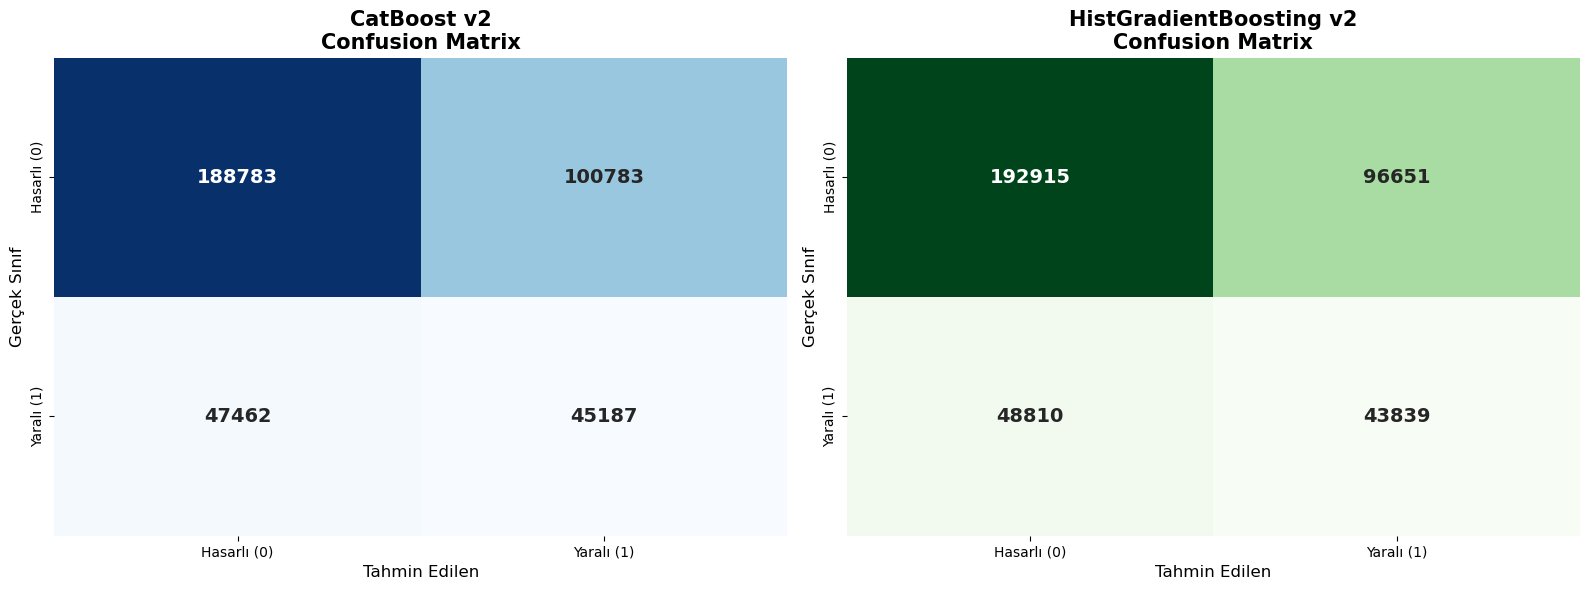

In [3]:
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# 1. Veri ve Model Hazırlığı
FEATURES = ['LOCATION_TYPE', 'ROAD_TYPE_ARTERIES_HIGHWAYS', 'ROAD_TYPE_LOCAL_MAIN_ROADS', 
            'ROAD_TYPE_SPECIAL_AREAS', 'IS_MULTI_VEHICLE', 'HOUR']
TARGET = "SEVERITY"

# Veriyi yükle
df = pd.read_csv("NYC_Crash_Model_Final_Last.csv").dropna()
X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES], df[TARGET], test_size=0.2, random_state=42, stratify=df[TARGET]
)

# Modelleri yükle
cat_model = joblib.load("best_catboost_model_enes_v2.pkl")
hgb_model = joblib.load("best_hgb_model_enes_v2.pkl")

models = {"CatBoost v2": cat_model, "HistGradientBoosting v2": hgb_model}

# 2. Grafik Çizimi
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (name, model) in enumerate(models.items()):
    # Tahminler
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    
    # Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' if i==0 else 'Greens', 
                ax=axes[i], cbar=False, annot_kws={"size": 14, "weight": "bold"})
    
    axes[i].set_title(f"{name}\nConfusion Matrix", fontsize=15, weight='bold')
    axes[i].set_xlabel("Tahmin Edilen", fontsize=12)
    axes[i].set_ylabel("Gerçek Sınıf", fontsize=12)
    axes[i].set_xticklabels(['Hasarlı (0)', 'Yaralı (1)'])
    axes[i].set_yticklabels(['Hasarlı (0)', 'Yaralı (1)'])

plt.tight_layout()
plt.show()

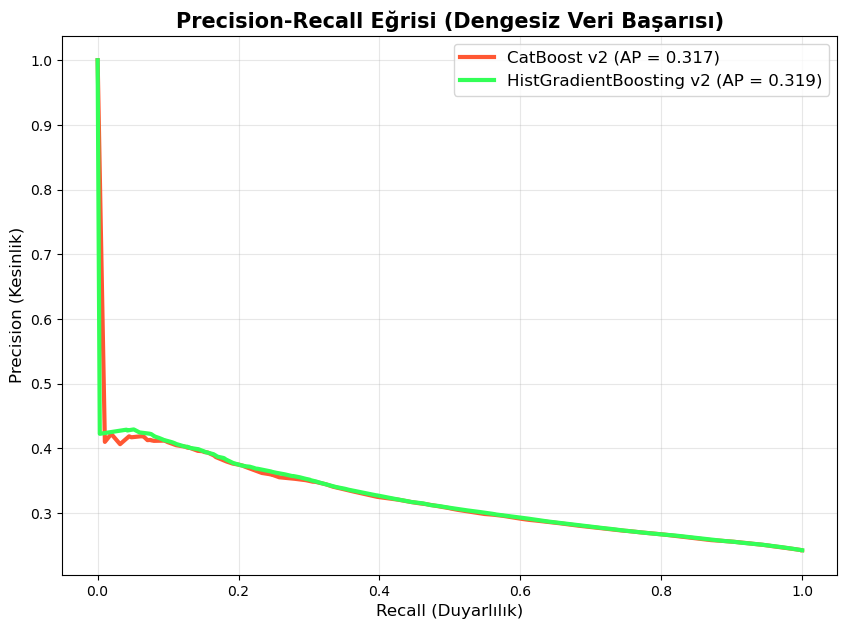

In [5]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 7))

colors = ['#FF5733', '#33FF57'] # Turuncu ve Yeşil

for i, (name, model) in enumerate(models.items()):
    # Olasılıkları al (Yaralı sınıfı için)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Eğriyi hesapla
    precision, recall, _ = precision_recall_curve(y_test, probs)
    avg_prec = average_precision_score(y_test, probs)
    
    plt.plot(recall, precision, lw=3, color=colors[i], 
             label=f'{name} (AP = {avg_prec:.3f})')

plt.xlabel('Recall (Duyarlılık)', fontsize=12)
plt.ylabel('Precision (Kesinlik)', fontsize=12)
plt.title('Precision-Recall Eğrisi (Dengesiz Veri Başarısı)', fontsize=15, weight='bold')
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Modeller dosyalardan yükleniyor...
Tahminler alınıyor ve skorlar hesaplanıyor...


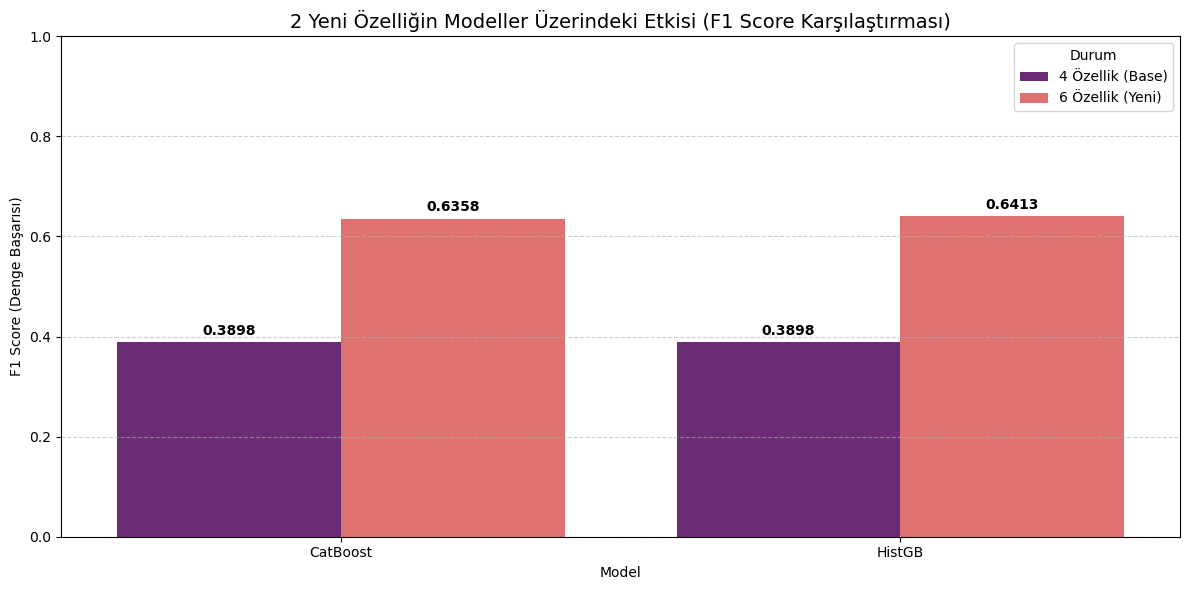

***KAYDEDİLEN MODELLERDEN GELEN GÜNCEL SONUÇLAR***


,Model,Versiyon,F1 Score,Accuracy,Recall
0,CatBoost,(4 Özellik),0.389759,0.391696,0.820549
1,CatBoost,(6 Özellik+Bal),0.635811,0.612142,0.487722
2,HistGB,(4 Özellik),0.389759,0.391696,0.820549
3,HistGB,(6 Özellik+Bal),0.641339,0.619426,0.473173


In [48]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, recall_score

# 1. Kaydettiğimiz modelleri geri yüklüyoruz
print("Modeller dosyalardan yükleniyor...")
cat_v1 = joblib.load("best_catboost_model_enes.pkl")       # 4 Özellikli
cat_v2 = joblib.load("best_catboost_model_enes_v2.pkl")    # 6 Özellikli + Balanced
hgb_v1 = joblib.load("best_hgb_model_enes.pkl")           # 4 Özellikli
hgb_v2 = joblib.load("best_hgb_model_enes_v2.pkl")        # 6 Özellikli + Balanced

# 2. Skorları hesaplamak için bir fonksiyon oluşturalım (Kod tekrarı yapmamak için)
def model_skorlarini_al(model, X_test_data, y_true, model_label):
    y_pred = model.predict(X_test_data)
    return {
        'Model': model_label.split(" ")[0],
        'Versiyon': " ".join(model_label.split(" ")[1:]),
        'F1 Score': f1_score(y_true, y_pred, average='weighted'),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred)
    }

# 3. Skorları dinamik olarak hesaplıyoruz
# NOT: V1 modelleri sadece ilk 4 özelliği bilir, V2 modelleri 6 özelliği de kullanır.
v1_features = ['LOCATION_TYPE', 'ROAD_TYPE_ARTERIES_HIGHWAYS', 'ROAD_TYPE_LOCAL_MAIN_ROADS', 'ROAD_TYPE_SPECIAL_AREAS']

print("Tahminler alınıyor ve skorlar hesaplanıyor...")
results = []
results.append(model_skorlarini_al(cat_v1, X_test[v1_features], y_test, "CatBoost (4 Özellik)"))
results.append(model_skorlarini_al(cat_v2, X_test, y_test, "CatBoost (6 Özellik+Bal)"))
results.append(model_skorlarini_al(hgb_v1, X_test[v1_features], y_test, "HistGB (4 Özellik)"))
results.append(model_skorlarini_al(hgb_v2, X_test, y_test, "HistGB (6 Özellik+Bal)"))

df_dynamic = pd.DataFrame(results)

# Görselleştirme
plt.figure(figsize=(12, 6))
sns.barplot(data=df_impact, x='Model', y='F1 Score', hue='Durum', palette='magma')

plt.title('2 Yeni Özelliğin Modeller Üzerindeki Etkisi (F1 Score Karşılaştırması)', fontsize=14)
plt.ylabel('F1 Score (Denge Başarısı)')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Çubukların üzerine değerleri otomatik yazdır
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{p.get_height():.4f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', xytext=(0, 8), 
                           textcoords='offset points', weight='bold')

plt.tight_layout()
plt.show()

print("***KAYDEDİLEN MODELLERDEN GELEN GÜNCEL SONUÇLAR***")
display(df_dynamic)